In [41]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go
from utils import parse_real_disp, CABC_Displacement, CABC_Force, parse_real_force, calculate_area_between_curves
import datetime
import pickle

torch.set_default_dtype(torch.float64)

In [42]:
file_info = [
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar03mms388g.txt",  #0
        "force_start"   : "31.07.2025 10:39:06.150461",
        "force_end"     : "31.07.2025 10:39:24.070461",
        "pos_start"     : "31.07.2025 10:39:24.070461",
        "pos_end"       : "31.07.2025 10:42:34.610461"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar07mms384g.txt",  #1
        "force_start"   : "31.07.2025 10:18:27.193997",
        "force_end"     : "31.07.2025 10:18:35.113997",
        "pos_start"     : "31.07.2025 10:18:35.113997",
        "pos_end"       : "31.07.2025 10:20:44.573997"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar11mms414g.txt",  #2
        "force_start"   : "30.07.2025 13:43:44.197899",
        "force_end"     : "30.07.2025 13:43:49.057899",
        "pos_start"     : "30.07.2025 13:43:49.057899",
        "pos_end"       : "30.07.2025 13:46:49.957899"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar03mms396g.txt", #3
        "force_start"   : "29.07.2025 15:27:01.321079",
        "force_end"     : "29.07.2025 15:27:19.181079",
        "pos_start"     : "29.07.2025 15:27:19.181079",
        "pos_end"       : "29.07.2025 15:30:46.881079"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar07mms398g.txt", #4
        "force_start"   : "30.07.2025 12:19:49.167098",
        "force_end"     : "30.07.2025 12:19:57.487098",
        "pos_start"     : "30.07.2025 12:19:57.487098",
        "pos_end"       : "30.07.2025 12:21:55.287098"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar11mms393g.txt", #5
        "force_start"   : "30.07.2025 12:46:38.439119",
        "force_end"     : "30.07.2025 12:46:43.619119",
        "pos_start"     : "30.07.2025 12:46:43.619119",
        "pos_end"       : "30.07.2025 12:50:18.619119"
    },
    {
        "path" : "H:\\DLR Press Data\\60percent4STACKCENTER200bar11mms365g.txt",#6
        "force_start"   : "31.07.2025 11:00:47.633201",
        "force_end"     : "31.07.2025 11:00:53.213201",
        "pos_start"     : "31.07.2025 11:00:53.213201",
        "pos_end"       : "31.07.2025 11:06:35.493201"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar03mms508g.txt", #7
        "force_start"   : "30.07.2025 11:47:26.451826",
        "force_end"     : "30.07.2025 11:47:42.371826",
        "pos_start"     : "30.07.2025 11:47:42.371826",
        "pos_end"       : "30.07.2025 11:50:53.831826"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar07mms525g.txt", #8
        "force_start"   : "31.07.2025 14:21:37.055615",
        "force_end"     : "31.07.2025 14:21:43.535615",
        "pos_start"     : "31.07.2025 14:21:43.535615",
        "pos_end"       : "31.07.2025 14:24:04.975615"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar11mms531g.txt", #9
        "force_start"   : "31.07.2025 14:49:31.716399",
        "force_end"     : "31.07.2025 14:49:35.816399",
        "pos_start"     : "31.07.2025 14:49:35.816399",
        "pos_end"       : "31.07.2025 15:01:25.776399"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar03mms542g.txt", #10
        "force_start"   : "31.07.2025 09:07:08.361246",
        "force_end"     : "31.07.2025 09:07:23.161246",
        "pos_start"     : "31.07.2025 09:07:24.161246",
        "pos_end"       : "31.07.2025 09:09:48.641246"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar07mms527g.txt", #11
        "force_start"   : "30.07.2025 15:33:47.945013",
        "force_end"     : "30.07.2025 15:33:54.465013",
        "pos_start"     : "30.07.2025 15:33:54.465013",
        "pos_end"       : "30.07.2025 15:36:35.305013"
    },
    {
        "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar11mms543g.txt", #12
        "force_start"   : "31.07.2025 09:56:19.454633",
        "force_end"     : "31.07.2025 09:56:23.494633",
        "pos_start"     : "31.07.2025 09:56:23.494633",
        "pos_end"       : "31.07.2025 09:58:13.974633"  
    },
    {
        "path" : "H:\\DLR Press Data\\SPLITCONF80percent4STACKBAR150bar03mms518g.txt", #13
        "force_start"   : "31.07.2025 15:16:03.864139",
        "force_end"     : "31.07.2025 15:16:18.464139",
        "pos_start"     : "31.07.2025 15:16:18.464139",
        "pos_end"       : "31.07.2025 15:20:00.584139"  
    }

]

custom_groups = [
    [0, 1, 2],    
    [3, 4, 5],    
    [7, 8, 9],
    [10, 11, 12]         
]
custom_groups = [
    [  # 60% BAR config
        {"index": 0, "label": "60% BAR 0.3 mm/s"},
        {"index": 1, "label": "60% BAR 0.7 mm/s"},
        {"index": 2, "label": "60% BAR 1.1 mm/s"}
    ],
    [  # 60% CENTER config
        {"index": 3, "label": "60% CENTER 0.3 mm/s"},
        {"index": 4, "label": "60% CENTER 0.7 mm/s"},
        {"index": 5, "label": "60% CENTER 1.1 mm/s"}
    ],
    [  # 80% BAR
        {"index": 7, "label": "80% BAR 0.3 mm/s"},
        {"index": 8, "label": "80% BAR 0.7 mm/s"},
        {"index": 9, "label": "80% BAR 1.1 mm/s"}
    ],
    [  # 80% BAR
        {"index": 10, "label": "80% CENTER 0.3 mm/s"},
        {"index": 11, "label": "80% CENTER 0.7 mm/s"},
        {"index": 12, "label": "80% CENTER 1.1 mm/s"}
    ],
    

]

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_67920\688749954.py:33: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Intersection at t = 10.0 s


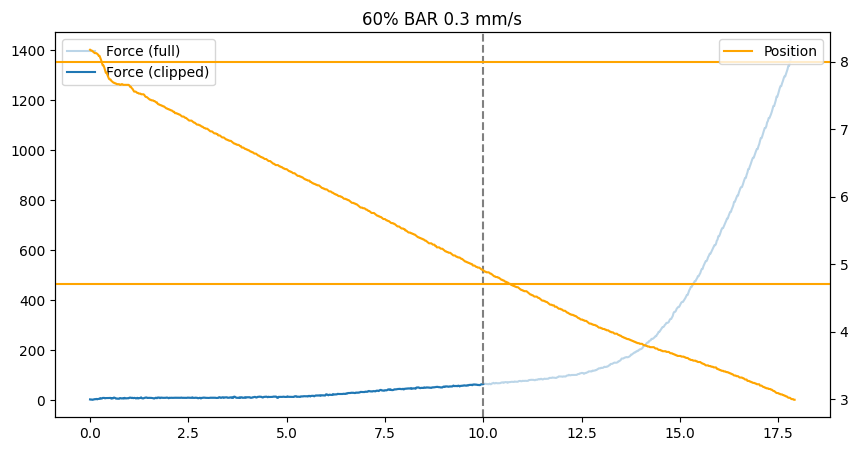

In [43]:
def get_label_from_index(custom_groups, idx):
    for group in custom_groups:
        for item in group:
            if item["index"] == idx:
                return item["label"]
    return f"Index {idx}"
# --- helper: first crossing time of y(t) with a target value ---
def first_crossing_time(t, y, target):
    """
    Returns the first time t* where y crosses target, using linear interpolation
    between consecutive points where (y - target) changes sign.
    If no crossing, returns None.
    """
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    d = y - target
    sign_change = np.where(np.diff(np.sign(d)) != 0)[0]
    if sign_change.size == 0:
        return None
    i = sign_change[0]
    # linear interpolation between (t[i], y[i]) and (t[i+1], y[i+1])
    t0, t1 = t[i], t[i+1]
    y0, y1 = y[i], y[i+1]
    if y1 == y0:
        return t0
    return t0 + (target - y0) * (t1 - t0) / (y1 - y0)

# -----------------------
index = 0
info = file_info[index]
label = get_label_from_index(custom_groups, index)

df = pd.read_csv(
    info["path"],
    encoding='utf-16-le',
    sep=';',
    skiprows=1,
    quotechar='"'
).rename(columns={
    'time': 'Time',
    'dbPr\\diIstPos': 'Pos',
    'dbPr\\diIstKraftGes': 'Force'
})

df = df[['Time', 'Pos', 'Force']]
df['Pos']   = pd.to_numeric(df['Pos'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
df['Force'] = pd.to_numeric(df['Force'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
df = df[df['Time'] != 'sec']
df['Time']  = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S.%f')

# Window
force_start = pd.to_datetime(info["force_start"], format='%d.%m.%Y %H:%M:%S.%f')
force_end   = pd.to_datetime(info["force_end"],   format='%d.%m.%Y %H:%M:%S.%f')
window_start = force_start
window_end   = force_end

dfw = df[(df['Time'] >= window_start) & (df['Time'] <= window_end)].copy()
dfw['Time_seconds'] = (dfw['Time'] - force_start).dt.total_seconds()

# ---- find crossing with thickness line ----
target_pos = 4.7   # or 6.39 for 80%
mask_after0 = dfw['Time_seconds'] >= 0
t_after0   = dfw.loc[mask_after0, 'Time_seconds'].values
pos_after0 = dfw.loc[mask_after0, 'Pos'].values

t_cross = first_crossing_time(t_after0, pos_after0, target_pos) - 0.7
print("Intersection at t =", t_cross, "s")

# ---- clip master force curve ----
dfw_clipped = dfw[dfw['Time_seconds'] <= t_cross].copy()

real_time  = dfw_clipped['Time_seconds'].to_numpy()
real_force = dfw_clipped['Force'].to_numpy() * 0.980665

# optional: resample
common_time = np.linspace(0.0, real_time.max(), num=200)
real_force_resampled = np.interp(common_time, real_time, real_force)

# ---- Plot to verify ----
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dfw['Time_seconds'], dfw['Force'], color='tab:blue', alpha=0.3, label="Force (full)")
ax1.plot(real_time, real_force, color='tab:blue', label="Force (clipped)")
ax1.axvline(t_cross, color='gray', linestyle='--')

ax2 = ax1.twinx()
ax2.plot(dfw['Time_seconds'], dfw['Pos'], color='orange', label="Position")
ax2.axhline(8.0, color='orange', linestyle='-')
ax2.axhline(target_pos, color='orange', linestyle='-')

ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.title(label)
plt.show()


In [44]:

# --- Use your clipped master curve here ---
MASTER_T = np.asarray(real_time, dtype=float)    # from your clipped dfw_clipped
MASTER_F = np.asarray(real_force, dtype=float)   # same length as MASTER_T

FORCE_SCALE = 9.80665  # set to 1.0 if XML force already matches master units

def mse_vs_master(master_t, master_f, guess_t, guess_f):
    """Interpolate guess onto master_t (overlap only) and return MSE."""
    guess_t = np.asarray(guess_t, float)
    guess_f = np.asarray(guess_f, float)

    if guess_t.size < 2:
        return np.inf

    # Ensure strictly increasing time for interp
    order = np.argsort(guess_t)
    guess_t = guess_t[order]
    guess_f = guess_f[order]

    # Overlap between master_t and guess_t range
    overlap = (master_t >= guess_t[0]) & (master_t <= guess_t[-1])
    if not np.any(overlap):
        return np.inf

    guess_on_master = np.interp(master_t[overlap], guess_t, guess_f)
    return float(np.mean((guess_on_master - master_f[overlap])**2))

guess_disp_data_all = {}
guess_force_data_all = {}
area_data = []
guess_data_all = {}
valid_xml = []

num_initial_samples = 30
for i in range(num_initial_samples):
    # --- parse one XML ---
    xml_path = f"H:\\XMLFiles\\60BAR_03\\study_{i + 1}.xml"
    guess_tree = ET.parse(xml_path)
    guess_root = guess_tree.getroot()

    guess_data = []
    count = 0
    for time_block, dept_block in zip(
        guess_root.findall('.//Block//IndpVar'),
        guess_root.findall('.//Block')
    ):
        if count >= 23:
            break
        time_value = time_block.attrib.get('Value')
        dept_value = dept_block.find('DeptValues').text.strip()
        guess_data.append((time_value, dept_value))
        count += 1

    if len(guess_data) < 23:
        print(f"Warning: File {i+1} has incomplete/corrupted data "
              f"(only {len(guess_data)} entries). Skipping.")
        continue

    # store raw pairs
    guess_data_all[f"guess_data_{i+1}"] = guess_data

    # to float arrays
    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]
    guess_force = guess_data_array[:, 1] * FORCE_SCALE  # unit-match master!

    # (optional) keep in globals as you did
    globals()[f"guess_time_{i+1}"] = guess_time
    globals()[f"guess_disp_{i+1}"] = guess_force  # name kept for backward compat

    # --- compute MSE against the CLIPPED master curve ---
    mean_s_error = mse_vs_master(MASTER_T, MASTER_F, guess_time, guess_force)
    area_data.append(mean_s_error)
    valid_xml.append(len(area_data) - 1)

print(guess_data_all)


{'guess_data_1': [('0.003334', '2.5669e+00'), ('0.068765', '2.9870e+00'), ('0.545763', '2.9902e+00'), ('1.307756', '3.3416e+00'), ('1.828318', '4.4187e+00'), ('2.451796', '5.3771e+00'), ('2.879154', '6.2003e+00'), ('3.405224', '6.8455e+00'), ('4.051563', '7.6036e+00'), ('4.485187', '8.5080e+00'), ('5.011768', '9.3077e+00'), ('5.465565', '1.0401e+01'), ('6.048372', '1.1470e+01'), ('6.470971', '1.3203e+01'), ('6.989615', '1.4528e+01'), ('7.352518', '1.6130e+01'), ('7.789419', '1.7719e+01'), ('8.243102', '1.9568e+01'), ('8.637798', '2.2062e+01'), ('9.113828', '2.4071e+01'), ('9.507250', '2.7468e+01'), ('9.888264', '2.9927e+01'), ('10.210508', '3.3332e+01')], 'guess_data_2': [('0.003334', '2.8422e-01'), ('0.056410', '2.4847e-01'), ('0.443339', '2.4944e-01'), ('1.208320', '2.7570e-01'), ('1.712094', '3.4202e-01'), ('2.358812', '4.7612e-01'), ('2.813743', '5.7014e-01'), ('3.387650', '6.3058e-01'), ('4.006558', '7.1377e-01'), ('4.379522', '8.2132e-01'), ('4.843118', '8.9914e-01'), ('5.399730'

In [45]:
print(area_data)
print(list(guess_data_all.keys()))
for name, lst in guess_data_all.items():
    array = np.array(lst)
    print(f"{name}: Shape = {array.shape}")

[11496.870836928652, 207.20991513864232, 3495.387981380533, 132.6077441234319, 104.11507991949739, 5317.131533675363, 455.8934204676633, 21302.870109323238, 744.8191337078654, 27223.466697377316, 1911.4599637479298, 12682.319347651572, 19194.814675569094, 250.44950362086172, 964.5313535293449, 627.1092281180586, 9742.524247878297, 3109.720410784159, 1748.0236302372823, 8082.5931807305915, 9483.155975465694, 12.928986713512732, 17250.65717788073, 10455.748484774627, 3067.9874549084852, 1635.498102808415, 8526.960467633839, 126.90200775628018, 4650.474103164473, 187.02543412657894]
['guess_data_1', 'guess_data_2', 'guess_data_3', 'guess_data_4', 'guess_data_5', 'guess_data_6', 'guess_data_7', 'guess_data_8', 'guess_data_9', 'guess_data_10', 'guess_data_11', 'guess_data_12', 'guess_data_13', 'guess_data_14', 'guess_data_15', 'guess_data_16', 'guess_data_17', 'guess_data_18', 'guess_data_19', 'guess_data_20', 'guess_data_21', 'guess_data_22', 'guess_data_23', 'guess_data_24', 'guess_data_2

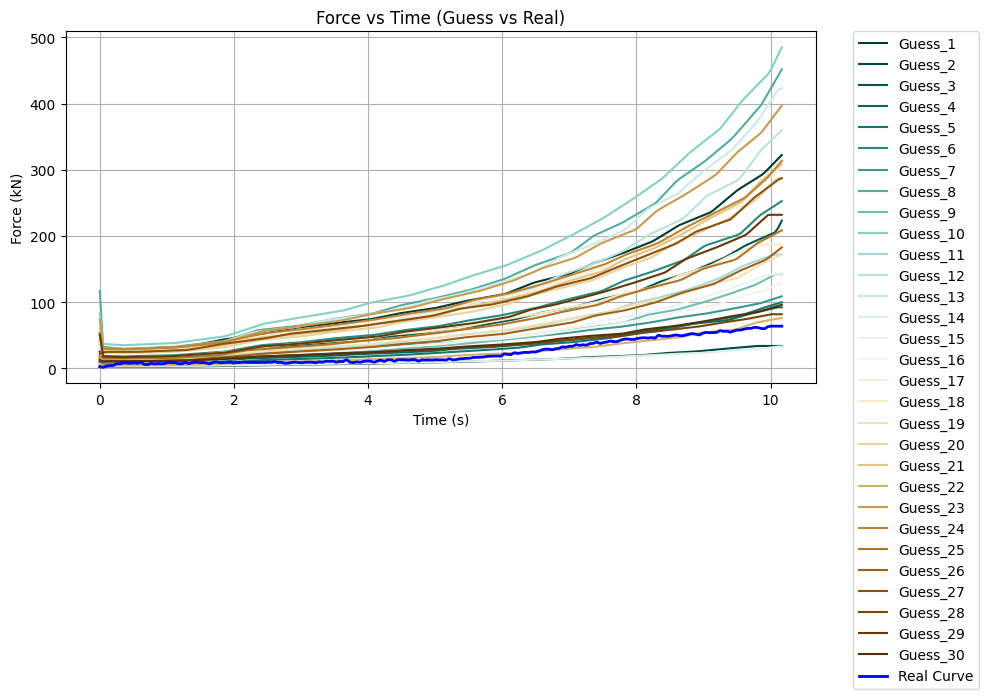

In [46]:
common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)
real_force_resampled = np.interp(common_time, real_time, real_force)

num_curves = len(guess_data_all)
colormap = plt.get_cmap('BrBG_r')

plt.figure(figsize=(10, 6))

for i, (key, guess_data) in enumerate(guess_data_all.items(), start=1):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_force = guess_data_array[:, 1] * 9.80665

    guess_force_resampled = np.interp(common_time, guess_time, guess_force)
    color = colormap((i - 1) / max(num_curves - 1, 1))
    plt.plot(common_time, guess_force_resampled, color=color, label=f'Guess_{i}')

plt.plot(common_time, real_force_resampled, 'b-', label='Real Curve', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')
plt.title('Force vs Time (Guess vs Real)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
import os, glob, numpy as np, pandas as pd, xml.etree.ElementTree as ET

# ---------- CONFIG ----------
# Map each config index (matching your file_info) to its XML folder with study_{i}.xml
CONFIG_FOLDERS = {
    0: r"H:\XMLFiles\60BAR_03",
    1: r"H:\XMLFiles\60BAR_07",
    2: r"H:\XMLFiles\60BAR_11",
    3: r"H:\XMLFiles\60CENTER_03",
    4: r"H:\XMLFiles\60CENTER_07",
    5: r"H:\XMLFiles\60CENTER_11",
    6: r"H:\XMLFiles\80BAR_03",
    7: r"H:\XMLFiles\80BAR_07",
    8: r"H:\XMLFiles\80BAR_11",
}
ACTIVE_CFGS = list(CONFIG_FOLDERS.keys())

NUM_RUNS = 30                       # i = 1..30
RIGHT_TRIM_S = 0                  # set to 0.7 if you want “end 0.7 s earlier”
FORCE_SCALE_CSV = 0.980665          # your CSV force scaling
FORCE_SCALE_XML = 9.80665           # set to 1.0 if your XML is already in same units as CSV master

# ---------- HELPERS ----------
def first_crossing_time(t, y, target):
    t = np.asarray(t, float); y = np.asarray(y, float)
    d = y - target
    idxs = np.where(np.diff(np.sign(d)) != 0)[0]
    if idxs.size == 0: return None
    i = idxs[0]
    t0, t1 = t[i], t[i+1]; y0, y1 = y[i], y[i+1]
    if y1 == y0: return t0
    return t0 + (target - y0) * (t1 - t0) / (y1 - y0)

def target_pos_from_label(label: str) -> float:
    # 60% → 4.7 (you used 4.7 above); 80% → 6.39
    return 4.7 if label.startswith("60%") else 6.39

def build_clipped_master(cfg_idx, right_trim_s=RIGHT_TRIM_S):
    """Return master (t_master, F_master) clipped at position threshold for a given config index."""
    info = file_info[cfg_idx]
    label = get_label_from_index(custom_groups, cfg_idx)
    target_pos = target_pos_from_label(label)

    df = pd.read_csv(info["path"], encoding='utf-16-le', sep=';', skiprows=1, quotechar='"')
    df = df.rename(columns={'time':'Time','dbPr\\diIstPos':'Pos','dbPr\\diIstKraftGes':'Force'})
    df = df[['Time','Pos','Force']]
    df['Pos']   = pd.to_numeric(df['Pos'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df['Force'] = pd.to_numeric(df['Force'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df = df[df['Time'] != 'sec']
    df['Time']  = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S.%f')

    # Window: force_start → force_end
    fs = pd.to_datetime(info["force_start"], format='%d.%m.%Y %H:%M:%S.%f')
    fe = pd.to_datetime(info["force_end"],   format='%d.%m.%Y %H:%M:%S.%f')
    win = df[(df['Time'] >= fs) & (df['Time'] <= fe)].copy()
    win['t'] = (win['Time'] - fs).dt.total_seconds()

    # Crossing at/after t=0
    mask0 = win['t'] >= 0
    t0 = win.loc[mask0, 't'].to_numpy()
    p0 = win.loc[mask0, 'Pos'].to_numpy()
    t_cross = first_crossing_time(t0, p0, target_pos)
    if t_cross is None:
        t_cross = win['t'].max()

    # Optional extra trim from the right
    t_end = max(0.0, t_cross - right_trim_s)

    seg = win[win['t'] <= t_end].copy()
    t_master = seg['t'].to_numpy()
    F_master = (seg['Force'].to_numpy()) * FORCE_SCALE_CSV
    return t_master, F_master, label, t_end

def parse_xml_force(xml_path, force_scale=FORCE_SCALE_XML):
    """Return sim (t, F) sorted by t (and shifted to start at 0)."""
    root = ET.parse(xml_path).getroot()
    ts, Fs = [], []
    for t_node, blk in zip(root.findall('.//Block//IndpVar'), root.findall('.//Block')):
        t = float(t_node.attrib.get('Value'))
        f = float(blk.find('DeptValues').text.strip())
        ts.append(t); Fs.append(f)
    t = np.asarray(ts, float); F = np.asarray(Fs, float) * force_scale
    if t.size >= 2:
        order = np.argsort(t); t, F = t[order], F[order]
    # shift so sim starts at 0 (robust wrt XML’s absolute origin)
    if t.size:
        t = t - t[0]
    return t, F

def mse_vs_master(master_t, master_f, sim_t, sim_f):
    """Interpolate sim onto master_t (overlap only) and compute MSE."""
    if sim_t.size < 2:
        return np.inf
    # Keep only sim within [0, master_t.max()]
    mask = (sim_t >= 0.0) & (sim_t <= master_t.max())
    sim_t = sim_t[mask]; sim_f = sim_f[mask]
    if sim_t.size < 2:
        return np.inf
    sim_on_master = np.interp(master_t, sim_t, sim_f, left=np.nan, right=np.nan)
    valid = ~np.isnan(sim_on_master)
    if not np.any(valid):
        return np.inf
    return float(np.mean((sim_on_master[valid] - master_f[valid])**2))

# ---------- BUILD MASTERS (once) ----------
masters = {}  # cfg -> dict(t, F, label, t_end)
for cfg in ACTIVE_CFGS:
    t_m, F_m, lbl, t_end = build_clipped_master(cfg, right_trim_s=RIGHT_TRIM_S)
    masters[cfg] = {"t": t_m, "F": F_m, "label": lbl, "t_end": t_end}

# ---------- COMPUTE GLOBAL LOSS PER RUN ----------
global_loss = np.full(NUM_RUNS, np.nan)
per_config_mse = {i: {} for i in range(1, NUM_RUNS+1)}

for i in range(1, NUM_RUNS+1):
    total = 0.0
    for cfg in ACTIVE_CFGS:
        xml_path = os.path.join(CONFIG_FOLDERS[cfg], f"study_{i}.xml")
        if not os.path.exists(xml_path):
            print(f"[warn] missing XML: cfg {cfg}, run {i} → {xml_path}")
            mse = np.inf
        else:
            try:
                sim_t, sim_F = parse_xml_force(xml_path)
                m = masters[cfg]
                mse = mse_vs_master(m["t"], m["F"], sim_t, sim_F)
            except Exception as e:
                print(f"[warn] parse/metric failed: cfg {cfg}, run {i}: {e}")
                mse = np.inf
        per_config_mse[i][cfg] = mse
        total += mse
    global_loss[i-1] = total

print("Global loss per run (sum of MSE across configurations):")
print(global_loss)

# ---------- OPTIONAL: SAVE RESULTS ----------
out_dir = r"H:\RepoCache\GLOBAL"
os.makedirs(out_dir, exist_ok=True)

# Save masters to reuse (avoid re-reading CSV later)
for cfg, m in masters.items():
    np.savez(os.path.join(out_dir, f"master_cfg_{cfg}.npz"),
             t=m["t"], F=m["F"], label=m["label"], t_end=m["t_end"])

# Save per-run losses and details
np.save(os.path.join(out_dir, "global_loss.npy"), global_loss)
# also a tidy CSV with per-config MSEs
rows = []
for i in range(1, NUM_RUNS+1):
    row = {"run": i, "global_loss": global_loss[i-1]}
    for cfg in ACTIVE_CFGS:
        row[f"mse_cfg_{cfg}"] = per_config_mse[i][cfg]
    rows.append(row)
pd.DataFrame(rows).to_csv(os.path.join(out_dir, "per_run_mse.csv"), index=False)


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_67920\3493969676.py:44: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(info["path"], encoding='utf-16-le', sep=';', skiprows=1, quotechar='"')
C:\Users\sozenosk\AppData\Local\Temp\ipykernel_67920\3493969676.py:44: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,22

Global loss per run (sum of MSE across configurations):
[1456954.72968753 1447603.42056615 1289985.53942975 1286817.3635311
 1246968.67231059 1598552.59725638 1243363.27206934 1916837.97908723
 1238817.13904161 5580952.06793719 1283399.78560265 1685618.89560512
 1779785.00893232 1233841.12988803 1492469.45306279 1456183.90451428
 1407012.78434207 1304665.28400163 1284545.68079326 1425732.07536747
 1670998.19068885 1183771.71412929 1691498.02185104 1392029.65986334
 1321479.09461589 1477796.4335354  1420107.89649764 1223819.84956269
 1511036.35979491 1223669.3975272 ]


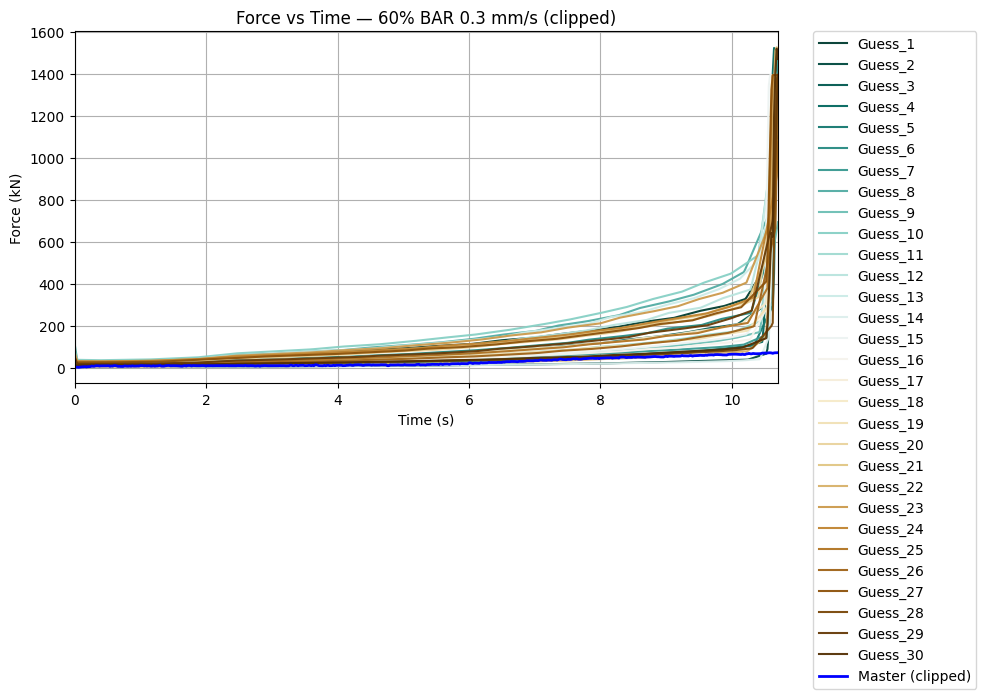

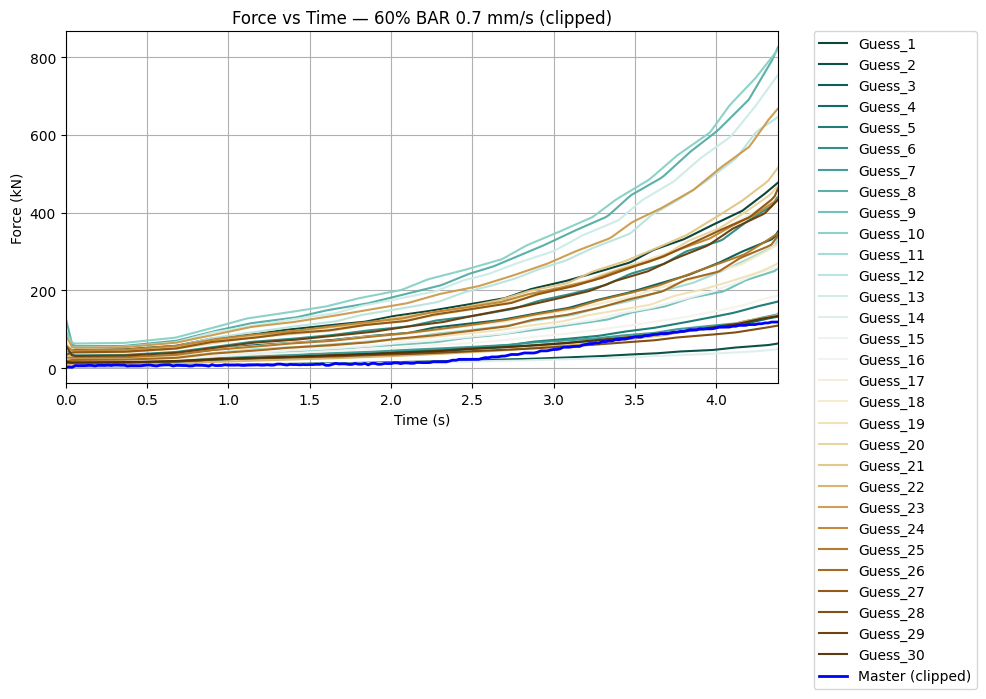

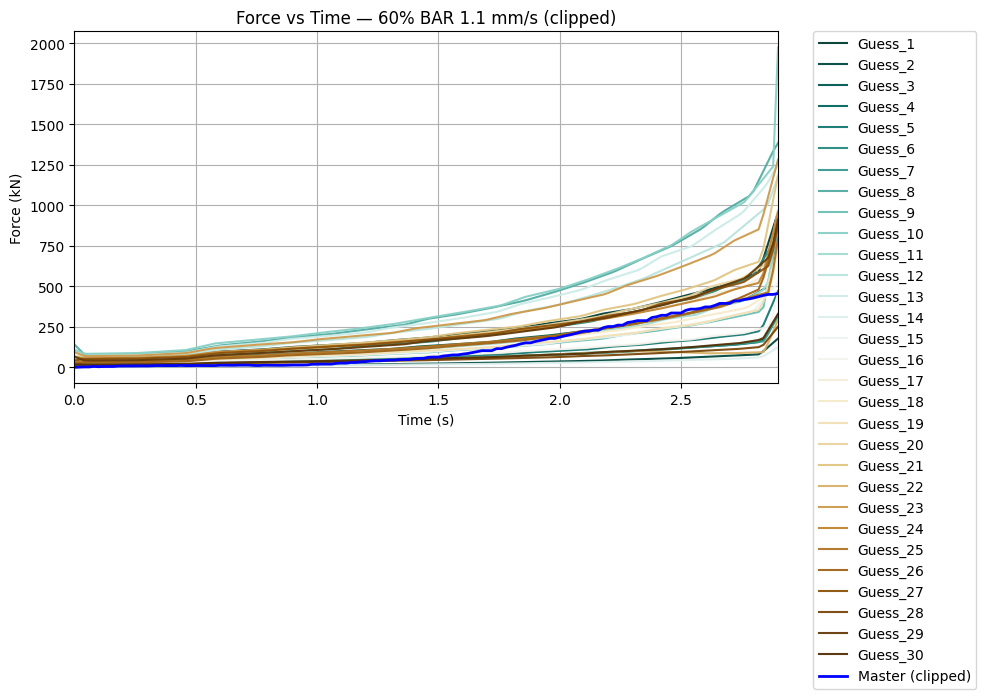

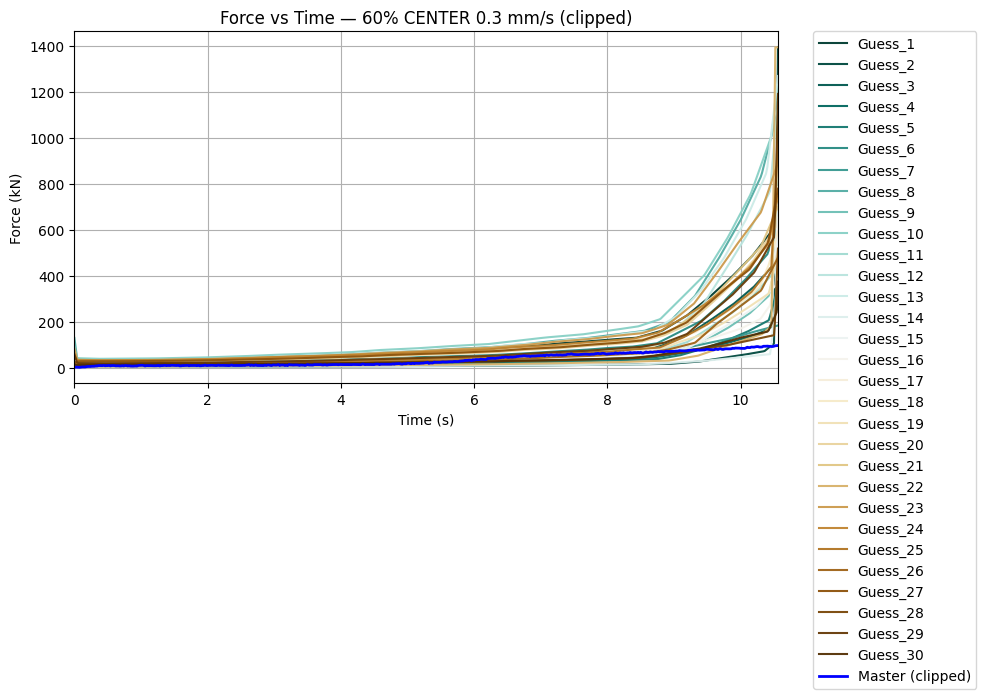

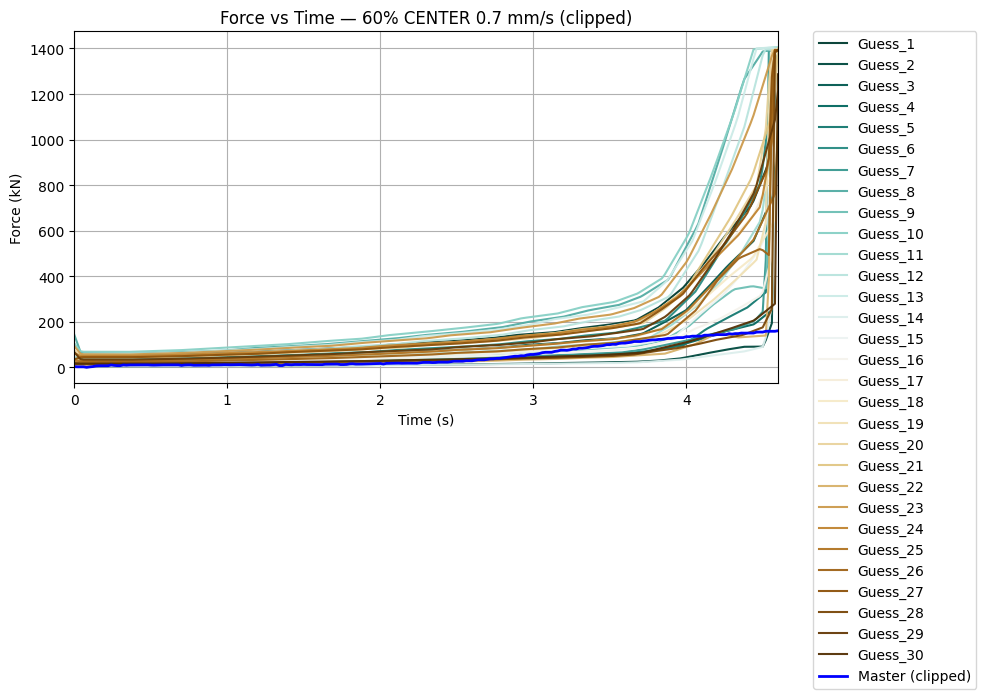

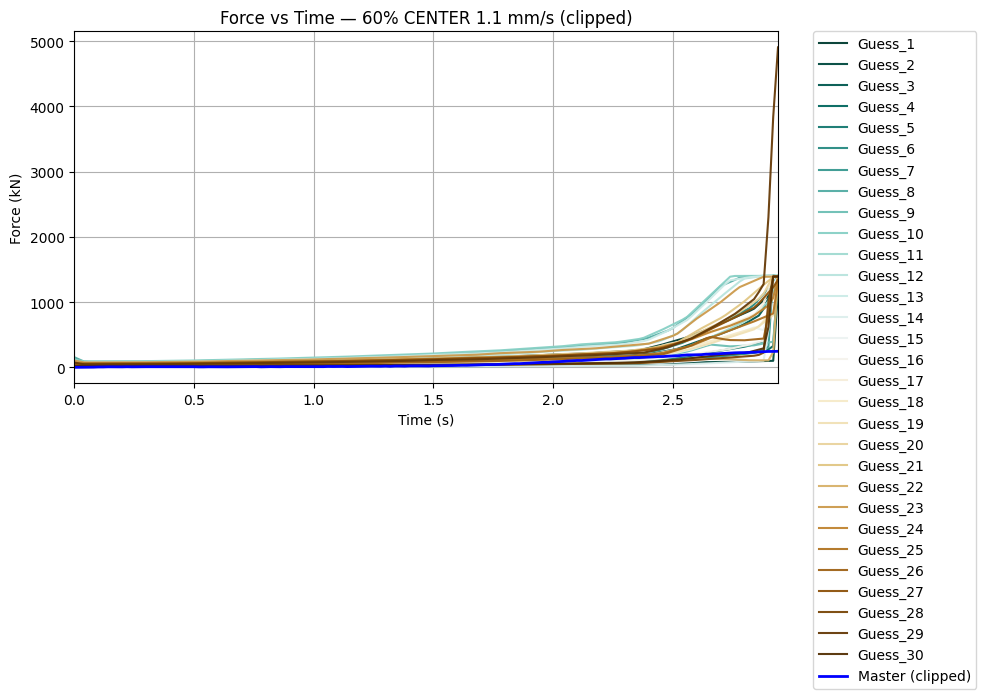

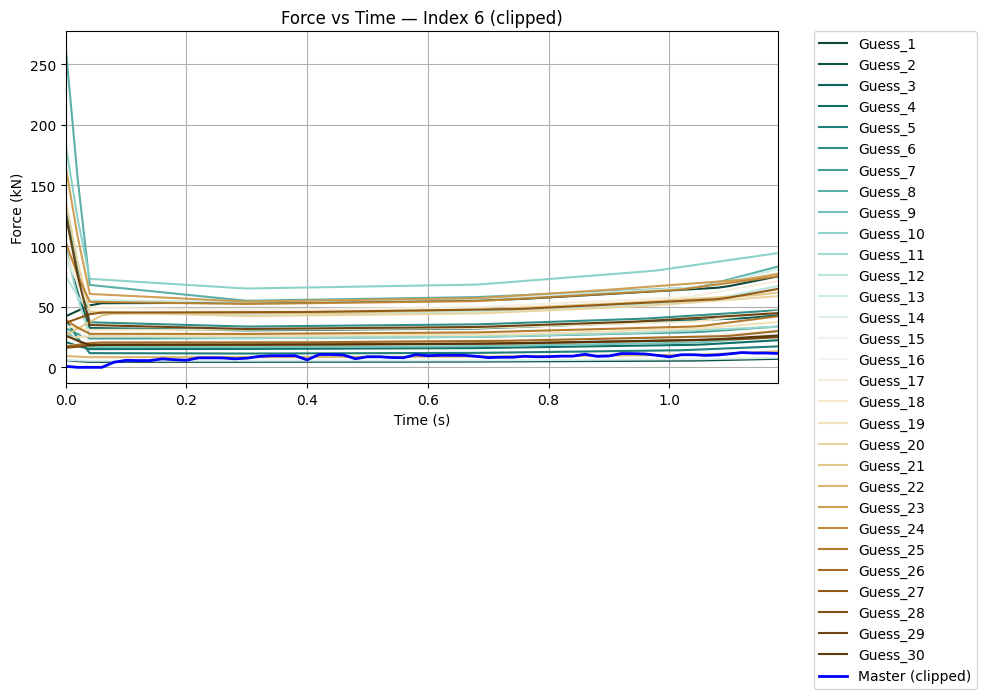

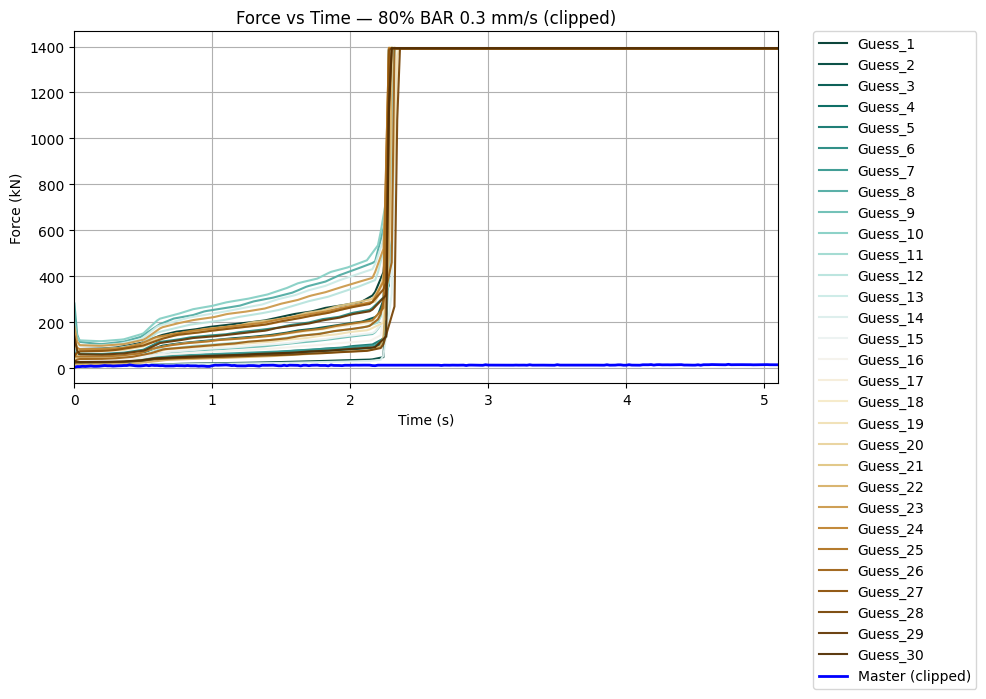

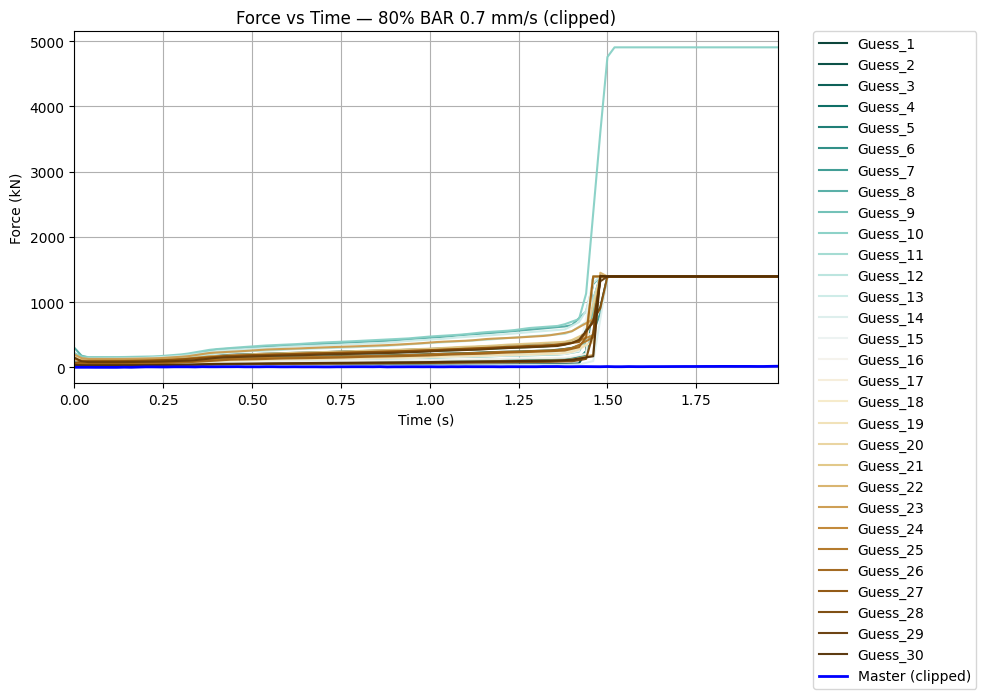

In [48]:
import os
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# assumes you already have:
# - masters[cfg] = {"t": t_master, "F": F_master, "label": label}
# - CONFIG_FOLDERS[cfg] -> folder containing study_{i}.xml for that cfg
# - ACTIVE_CFGS: list of cfg indices to plot
# - NUM_RUNS: number of XMLs per cfg (e.g., 30)
# - FORCE_SCALE_XML: set to 1.0 if XML force already matches master units

def parse_xml_force(xml_path, force_scale=1.0):
    root = ET.parse(xml_path).getroot()
    ts, Fs = [], []
    for t_node, blk in zip(root.findall('.//Block//IndpVar'), root.findall('.//Block')):
        t = float(t_node.attrib.get('Value'))
        f = float(blk.find('DeptValues').text.strip())
        ts.append(t); Fs.append(f)
    t = np.asarray(ts, float); F = np.asarray(Fs, float) * force_scale
    if t.size >= 2:
        order = np.argsort(t); t, F = t[order], F[order]
    if t.size:
        t = t - t[0]  # align start to 0 s
    return t, F

def plot_config_clipped(cfg, xml_folder, t_master, F_master, num_runs=30, label=None, force_scale_xml=1.0):
    # guard: if no master data, skip
    if t_master is None or len(t_master) < 2:
        print(f"[cfg {cfg}] empty master; skipping.")
        return
    label = label or f"cfg {cfg}"

    # color map
    colormap = plt.get_cmap('BrBG_r')

    plt.figure(figsize=(10, 6))

    # plot XML guesses strictly on master grid
    idx = 0
    for i in range(1, num_runs+1):
        xml_path = os.path.join(xml_folder, f"study_{i}.xml")
        if not os.path.exists(xml_path):
            continue
        try:
            gt, gF = parse_xml_force(xml_path, force_scale=force_scale_xml)
            if gt.size < 2:
                continue
            guess_on_master = np.interp(t_master, gt, gF)
            color = colormap((idx) / max(num_runs - 1, 1))
            plt.plot(t_master, guess_on_master, color=color, alpha=0.95, label=f'Guess_{i}')
            idx += 1
        except Exception as e:
            print(f"[cfg {cfg}] failed to parse/plot {xml_path}: {e}")

    # plot master (clipped) on top
    plt.plot(t_master, F_master, 'b-', linewidth=2, label='Master (clipped)')

    # hard-stop at clipped end
    plt.xlim(0.0, float(t_master.max()))

    plt.xlabel('Time (s)')
    plt.ylabel('Force (kN)')
    plt.title(f'Force vs Time — {label} (clipped)')
    plt.grid(True)
    # legend outside
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# ---- run for all configs ----
for cfg in ACTIVE_CFGS:
    m = masters[cfg]
    plot_config_clipped(
        cfg=cfg,
        xml_folder=CONFIG_FOLDERS[cfg],
        t_master=m["t"],
        F_master=m["F"],
        num_runs=NUM_RUNS,
        label=m.get("label", f"cfg {cfg}"),
        force_scale_xml=FORCE_SCALE_XML
    )


In [68]:
file_path = 'H:\\moldflow\\moldflow_automation\\combined_LHS_parameters.csv'
data = pd.read_csv(file_path)
n_values = data['n'].values
tau_star_values = data['tau_star'].values
B_values = data['B'].values
tau_w_values = data['tau_w'].values
m_values = data['m'].values

train_x = torch.tensor([[n_values[i], tau_star_values[i], B_values[i], tau_w_values[i], m_values[i]] for i in valid_xml ], dtype=torch.float64)
train_y = - torch.tensor([[global_loss[i]] for i in valid_xml], dtype=torch.float64)
train_yvar = torch.full_like(train_y, 1e-6)



bounds = torch.tensor([
    [0.2, 1e+3, 1e+3, 0.005, 1.0],
    [0.6, 1e+5, 1e+5, 1.0, 1.9]
], dtype= torch.float64
)



In [69]:
sim_dir = "G:\\Oskay Sözen\\Optimization\\Optimization.mpi"
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2026\\bin" 

In [ ]:
# ---- CHANGE THIS FOR EACH RUN ----
run_name = "Optim-1"  

save_dir = os.path.join(os.getcwd(), run_name)
os.makedirs(save_dir, exist_ok=True)

print(f"Saving all run data to: {save_dir}")

STUDY_NAMES = [
    "60BAR_4.70_03_study",
    "60BAR_4.70_07_study",
    "60BAR_4.70_11_study",
    "60CENTER_4.70_03_study",
    "60CENTER_4.70_07_study",
    "60CENTER_4.70_11_study",
    "80BAR_4.70_03_study",
    "80BAR_4.70_07_study",
    "80BAR_4.70_11_study",
]

CFG_KEYS = list(ACTIVE_CFGS)  # keep order
assert len(CFG_KEYS) == len(STUDY_NAMES), "ACTIVE_CFGS and STUDY_NAMES must align 1:1"
STUDY_BY_CFG = dict(zip(CFG_KEYS, STUDY_NAMES))

guess_data_all_optim = {}
num_iteration = 10
iterations=[]
for i in range(num_iteration):
    outcome_transform = Standardize(m=1)
    input_transform = Normalize(d=5)

    model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    model.eval()  

    acq_func =  LogExpectedImprovement(model, best_f=train_y.max())


    candidate_optim, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts=100, #Helps to ensure that we find the global optimum instead of finding the local optimum
            raw_samples=5000,  #More samples increases likelihood of finding good starting point.
    )

    print(f"Iteration {i+1}: Suggested new parameters (n, tau_star, B, tau_w, m)", candidate_optim)
    iterations.append(candidate_optim)

    Synergy.OpenProject(sim_dir)




    xml_paths_this_iter = {}

    for cfg in CFG_KEYS:
        study_name = STUDY_BY_CFG[cfg]
        Project = Synergy.Project
        Project.OpenItemByName(study_name, "Study")
        
        # Viscosity Parameters

        PropEd = Synergy.PropertyEditor
        Prop = PropEd.FindProperty(10090,1)
        Prop.FieldDescription(53030, f"{candidate_optim[0,0].item()}, {candidate_optim[0,1].item()}, {candidate_optim[0,2].item()} , 0.004, 0, 0, 0.305")
        PropEd.CommitChanges("Process Conditions")
        
        # Wall Slip Parameters

        PropEd = Synergy.PropertyEditor
        Prop = PropEd.FindProperty(10090, 1)
        DVec = Synergy.CreateDoubleArray
        
        DVec.AddDouble(candidate_optim[0,3].item())
        DVec.AddDouble(candidate_optim[0,4].item())
        DVec.AddDouble(1e-08)
        DVec.AddDouble(0)
        DVec.AddDouble(0)
        
        Prop.FieldValues(51182, DVec)
            
        PropEd.CommitChanges("Process Conditions")

        StudyDoc = Synergy.StudyDoc
        StudyDoc.SaveAs(f"optimization_{i+1}")
        

        p = subprocess.Popen(
        [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\Optimization\\optimization_{i+1}.sdy"],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        )
        (output, err) = p.communicate()
        time.sleep(3)
        subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"])
        time.sleep(2)

        Synergy.OpenProject("G:\\Oskay Sözen\\Optimization\\Optimization.mpi")         # PROJECT NAME!!!!!!!!!!!!!!!!
        Project = Synergy.Project
        Project.OpenItemByName(f"{study_name}_opt_1", "Study")
        
        PlotMgr = Synergy.PlotManager
        time.sleep(2)
        Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
        Pid = Plot.GetDataID
        PlotMgr = None
        PlotMgr = Synergy.PlotManager
        time.sleep(2)
        PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\Optimization\\{study_name}_optimization_{i + 1}.xml", "Metric")

        # Write the output to a log file
        with open(f"H:\\Log_Files\\Optimization\\{study_name}_optimization_{i+1}.log", "w") as file:
            file.write(output.decode("windows-1252").strip())






Saving all run data to: h:\moldflow\moldflow_automation\Optim-1


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 1: Suggested new parameters (n, tau_star, B, tau_w, m) tensor([[2.0000e-01, 8.2911e+04, 6.0175e+04, 6.8741e-01, 1.2259e+00]])


In [54]:
for cfg in CFG_KEYS:
    print(study_name[cfg])

60BAR_4.70_03_study
60BAR_4.70_07_study
60BAR_4.70_11_study
60CENTER_4.70_03_study
60CENTER_4.70_07_study
60CENTER_4.70_11_study
80BAR_4.70_03_study
80BAR_4.70_07_study
80BAR_4.70_11_study
